In [2]:
%matplotlib inline

In [3]:
from utils.config import *
from utils.utils import *
from utils.dataset import DamageDataset
from utils.model import DamageModel
from utils.lr_finder import LRFinder

import numpy as np
import pandas as pd
import os
import cv2
import albumentations as A
from PIL import Image
import json
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm, trange

import torch
from torch.utils.data import DataLoader
from torchvision import transforms
import torchvision.models as models
from torch.utils.tensorboard import SummaryWriter

In [4]:
create_files(results_config.values())
save_logs(config, config['logs_path'])

#### Metadata

In [5]:
metadata = pd.read_csv(config['metadata_path'])#.drop(columns='Unnamed: 0')
metadata = metadata[metadata['class'] != 'unknown'].reset_index(drop = True)
metadata = pd.concat([pd.get_dummies(metadata['class']), metadata], axis = 1)

In [5]:
cat_names = list(metadata.columns.values)
cat_names.remove('image')
cat_names.remove('class')
cat_names.remove('subset')
metadata = metadata.loc[:, ['image', 'class', 'subset']]
data_path = config['data_path']
print(cat_names)

['bumper_dent', 'bumper_scratch', 'crashed', 'door_dent', 'door_scratch', 'glass_shatter', 'head_lamp', 'no_damage', 'tail_lamp']


In [10]:
train_metadata = metadata[metadata['subset'] == 'T'].reset_index(drop = True)
valid_metadata = metadata[metadata['subset'] == 'V'].reset_index(drop = True)

#### Augmentations

In [11]:
image_transforms = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))
])

In [12]:
train_augmentations = A.Compose([
    A.GaussianBlur(),
    A.ShiftScaleRotate(),
    A.HorizontalFlip(),
    A.RandomBrightnessContrast(),
    A.Resize(*config['image_size'])
])

valid_augmentations = A.Compose([
    A.Resize(*config['image_size'])
])

#### Dataloader

In [13]:
train_dataset = DamageDataset(train_metadata, image_transforms, cat_names, data_path, augmentations=train_augmentations)
valid_dataset = DamageDataset(valid_metadata, image_transforms, cat_names, data_path, augmentations=valid_augmentations)

train_loader = DataLoader(train_dataset, batch_size=config['batch_size'], shuffle=True, num_workers=0)
valid_loader = DataLoader(valid_dataset, batch_size=config['batch_size'], shuffle=False, num_workers=0)

#### Model

In [10]:
if torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')

In [11]:
model = DamageModel(models.resnet50(pretrained=True), len(cat_names))
model.to(device)
model.train()

for p in model.parameters():
    assert p.requires_grad == True
    assert p.is_cuda == True

In [12]:
optimizer = torch.optim.Adam(params=model.parameters(), lr=config['lr'])
criterion = torch.nn.NLLLoss()

if config['lr_finder'] == False:
    scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr=config['lr'], epochs=config['num_epochs'], steps_per_epoch=len(train_loader))

In [13]:
if config['lr_finder']:
    lr_finder = LRFinder(model, optimizer, criterion)
    lr_finder.range_test(train_loader, end_lr=1, num_iter=100, start_lr=1e-6)
    lr_finder.plot()

In [14]:
writer = SummaryWriter(config['tensorboard_path'])

In [15]:
train_batch_ct = 0
valid_epoch = 0

#### Training

In [16]:
config['tensorboard_path']

'C:/Users/Andre/Documents/CVC_Project/results/exp/tensorboard'

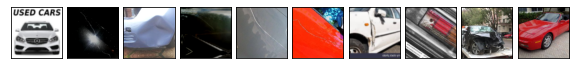

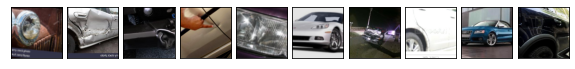

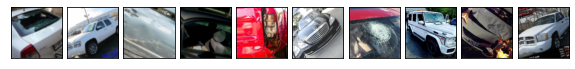

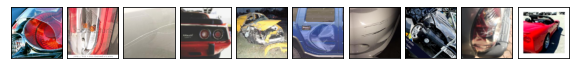

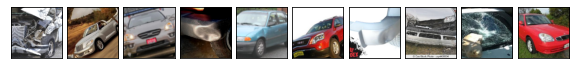

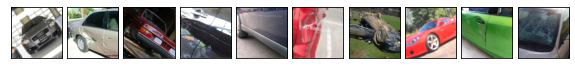

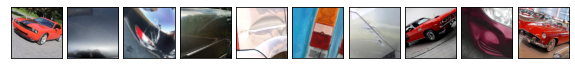

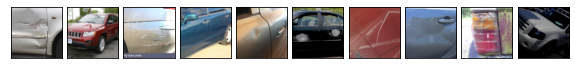

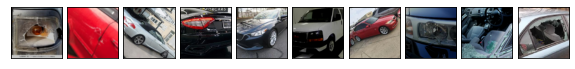

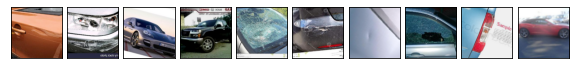

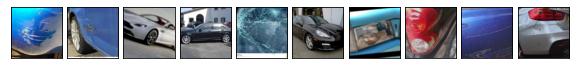

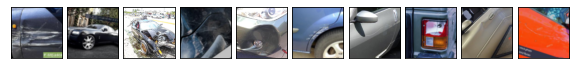

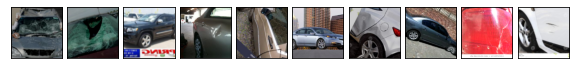

In [17]:
for epoch in trange(config['num_epochs']):
    model.train()
    for x, target, images in tqdm(train_loader, total=len(train_loader), desc='Train_' + str(epoch)):
        x = x.to(device)
        target = target.to(device)
        images = images.numpy()
        
        # clear gradients
        optimizer.zero_grad()
        
        output = model(x)
        loss = criterion(output, target)
        loss.backward()
        
        optimizer.step()
        scheduler.step()
        
        if train_batch_ct % config['valid_step'] == 0:
            validate(model, valid_loader, valid_epoch, criterion, writer, device)
            #save_model(valid_epoch, model, optimizer, config['checkpoints_path'])
            valid_epoch += 1
        
        if train_batch_ct % 50 == 0:
            gallery(images, plot_labels=False)            
            
        writer.add_scalar('Train/loss', loss.item(), train_batch_ct)
        writer.add_scalar('Train/lr', get_lr(optimizer), train_batch_ct)
        train_batch_ct += 1
        
        del loss, x, target, output

In [18]:
validate(model, valid_loader, valid_epoch, criterion, writer, device)
save_model(valid_epoch, model, optimizer, config['checkpoints_path'])
valid_epoch += 1

#### Inference

In [4]:
test_loader = DataLoader(valid_dataset, batch_size=1, shuffle=False, num_workers=0)

NameError: name 'DataLoader' is not defined

In [20]:
_ = model.eval()


In [1]:
cat_names

NameError: name 'cat_names' is not defined

In [21]:
target_labels = []
output_labels = []

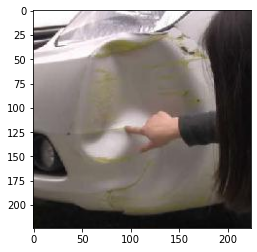

output:  bumper_dent
target:  bumper_dent


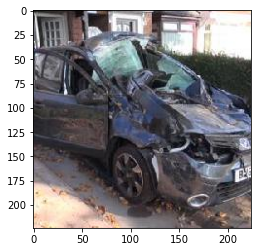

output:  crashed
target:  crashed


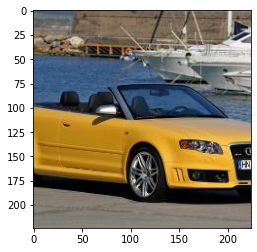

output:  no_damage
target:  no_damage


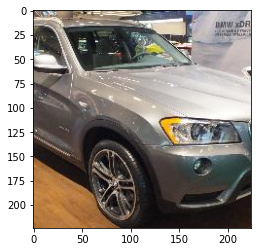

output:  no_damage
target:  no_damage


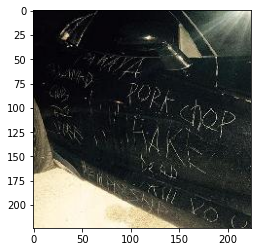

output:  door_scratch
target:  door_scratch


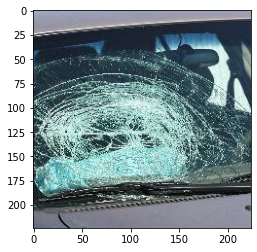

output:  glass_shatter
target:  glass_shatter


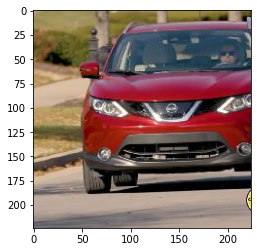

output:  no_damage
target:  no_damage


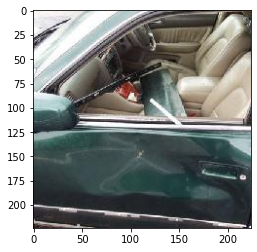

output:  glass_shatter
target:  door_dent


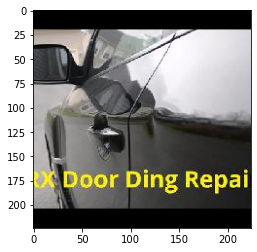

output:  door_dent
target:  door_dent


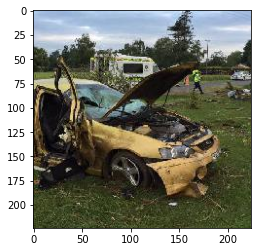

output:  crashed
target:  crashed


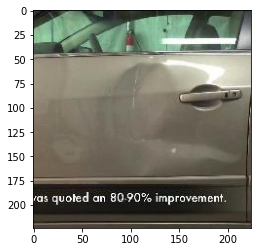

output:  door_dent
target:  door_dent


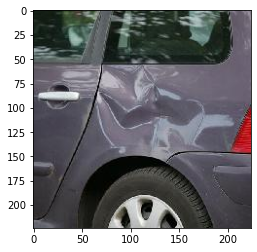

output:  door_dent
target:  door_dent


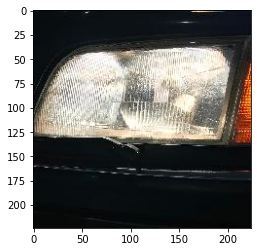

output:  head_lamp
target:  head_lamp


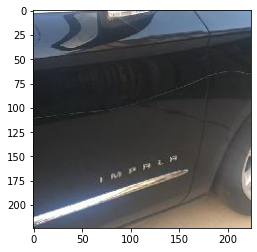

output:  door_scratch
target:  door_scratch


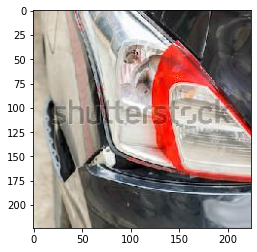

output:  tail_lamp
target:  tail_lamp


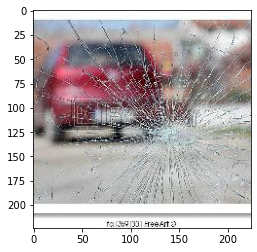

output:  tail_lamp
target:  glass_shatter


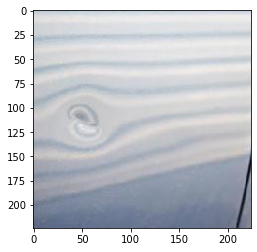

output:  door_dent
target:  door_dent


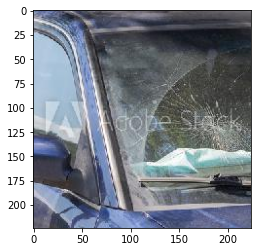

output:  glass_shatter
target:  glass_shatter


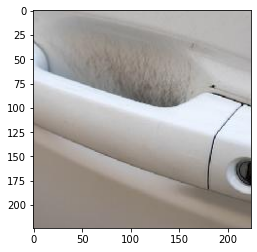

output:  door_dent
target:  door_scratch


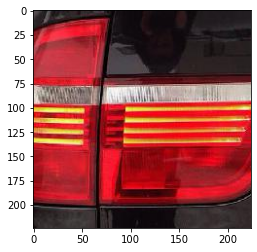

output:  tail_lamp
target:  no_damage


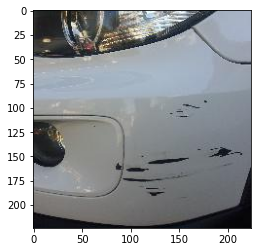

output:  bumper_scratch
target:  bumper_scratch


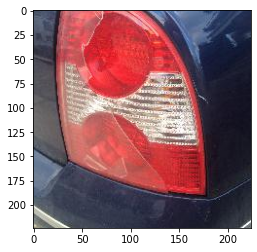

output:  tail_lamp
target:  tail_lamp


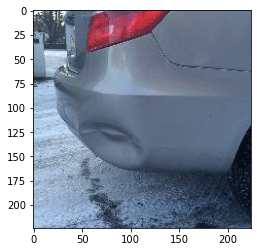

output:  bumper_dent
target:  bumper_dent


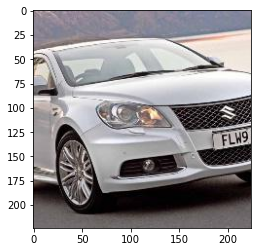

output:  no_damage
target:  no_damage


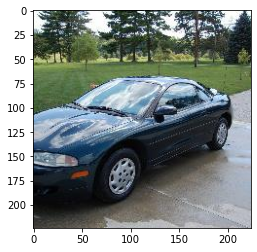

output:  no_damage
target:  no_damage


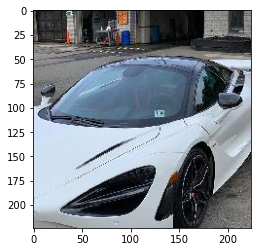

output:  no_damage
target:  no_damage


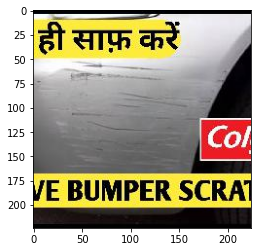

output:  no_damage
target:  bumper_scratch


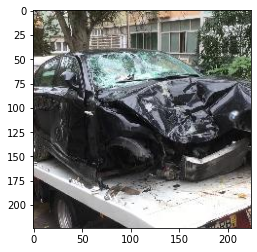

output:  crashed
target:  crashed


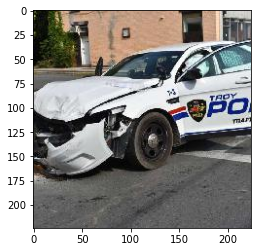

output:  crashed
target:  crashed


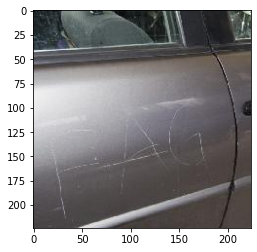

output:  door_scratch
target:  door_scratch


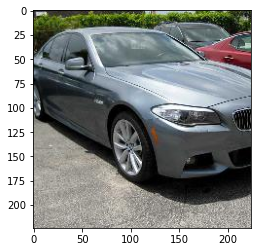

output:  no_damage
target:  no_damage


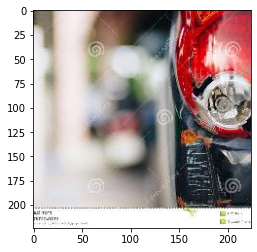

output:  tail_lamp
target:  tail_lamp


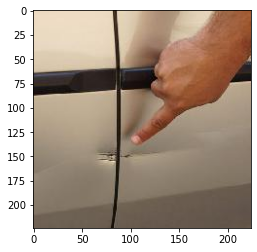

output:  door_dent
target:  door_dent


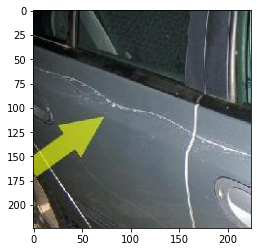

output:  door_scratch
target:  door_scratch


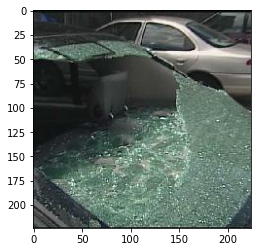

output:  glass_shatter
target:  glass_shatter


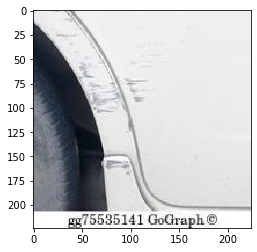

output:  door_scratch
target:  door_scratch


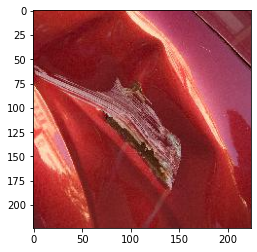

output:  door_dent
target:  door_dent


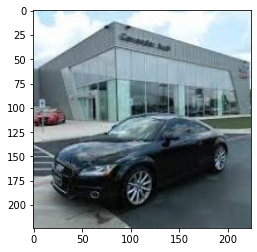

output:  no_damage
target:  no_damage


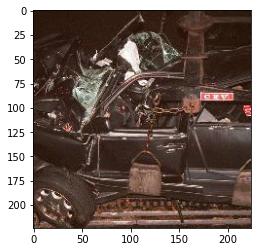

output:  crashed
target:  crashed


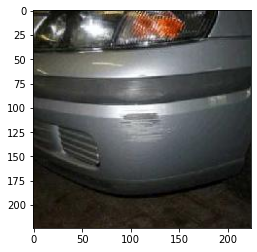

output:  bumper_scratch
target:  bumper_scratch


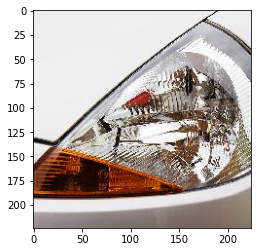

output:  tail_lamp
target:  head_lamp


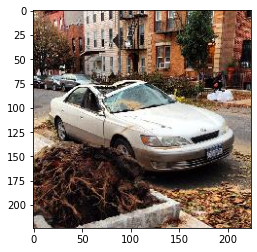

output:  crashed
target:  crashed



In [26]:
with torch.no_grad():
    for i, (x, target, image) in enumerate(tqdm(test_loader, total=len(test_loader))):
        plt.imshow(image.squeeze())
        plt.show()
        x = x.to(device)
        output = model(x).argmax().cpu().numpy()
        target = target.numpy()[0]
        print('output: ', cat_names[output])
        print('target: ', cat_names[target])
        
        if i > 40:
            break
#         target_label = cat_names[target]
#         output_label = cat_names[output]
        
#         target_labels.append(target_label)
#         output_labels.append(output_label)

#         del x, output
#         break